In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier



In [203]:
#Marketing Dataset

In [2]:
df = pd.read_csv('bank-additional-full.csv',sep=';',)

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df['y'] = df['y'].map({'no':0, 'yes':1})

df['y'].value_counts() 

0    36548
1     4640
Name: y, dtype: int64

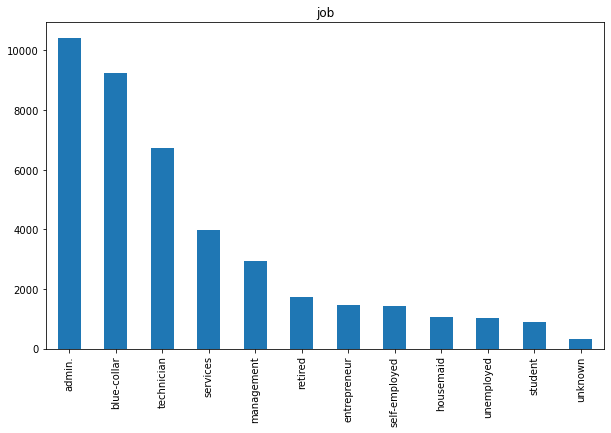

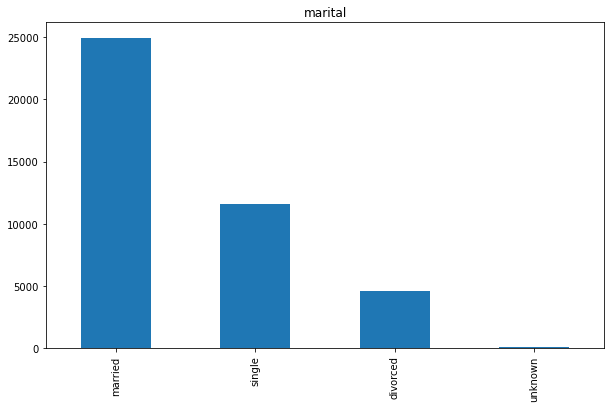

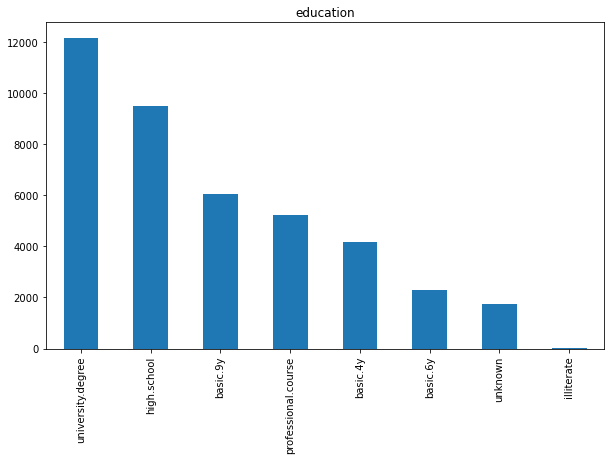

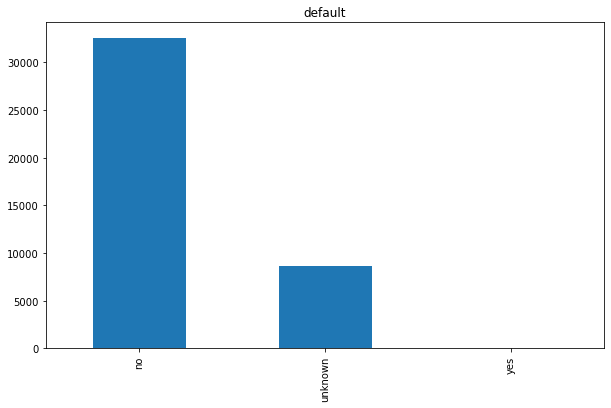

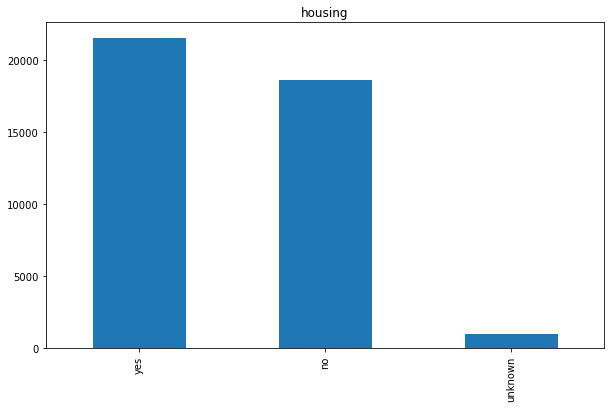

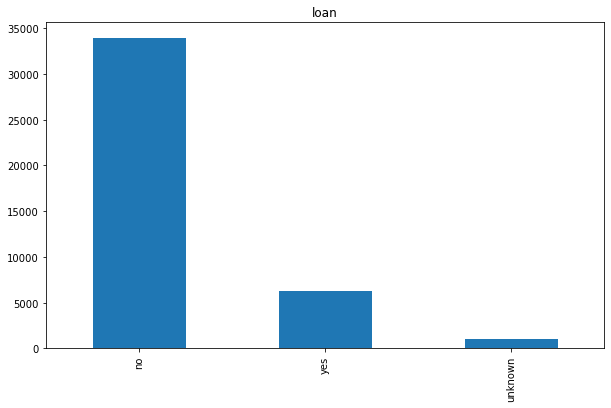

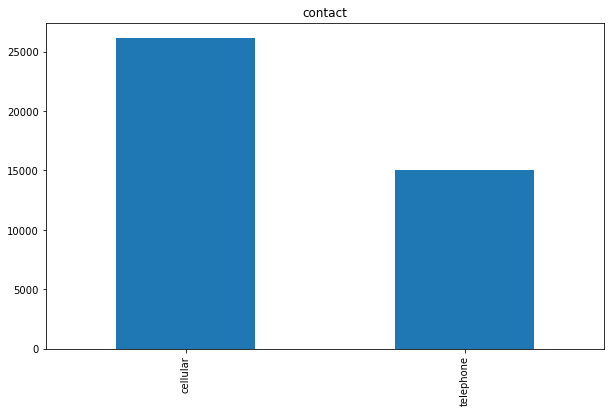

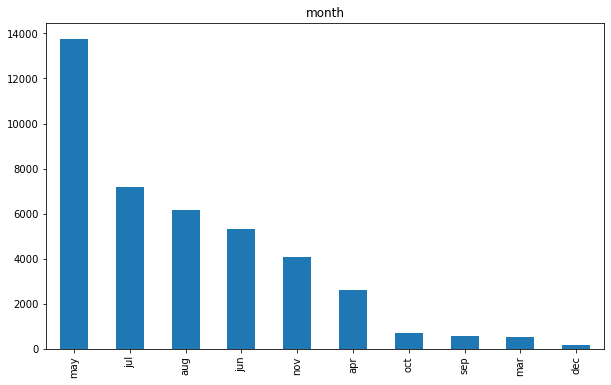

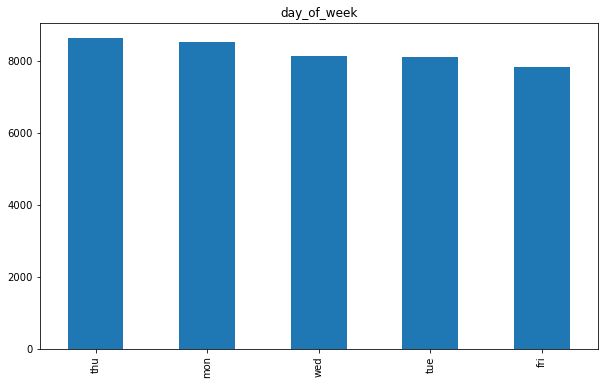

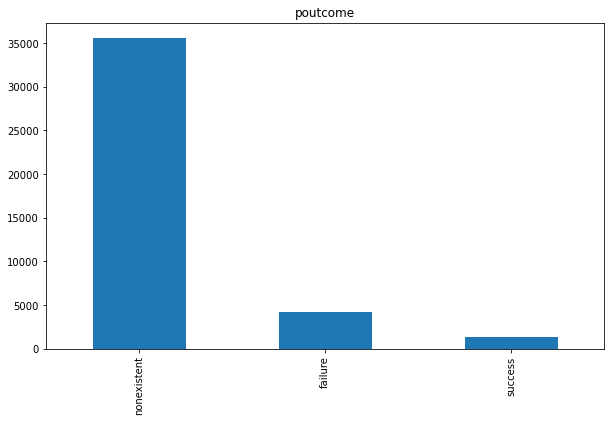

In [5]:
categorical = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for cat in categorical:
    df[cat].value_counts().plot(kind='bar',figsize = (10, 6), title=cat)
    plt.show()

In [6]:
scaler = MinMaxScaler() 

classes = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

df[classes] = scaler.fit_transform(df[classes])

In [7]:
ndf = pd.get_dummies(df)
ndf = ndf.drop('duration', axis=1)

In [8]:
#random.seed(5634200)

split = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state=18)

for train_idx, test_idx in split.split(ndf, ndf['y']):
    train_set = ndf.loc[train_idx]
    test_set = ndf.loc[test_idx]



In [17]:
train_set['y'].value_counts()/len(train_set)

0    0.887344
1    0.112656
Name: y, dtype: float64

In [18]:
test_set['y'].value_counts()/len(test_set)

0    0.887351
1    0.112649
Name: y, dtype: float64

In [19]:
train_neg = train_set[train_set['y']==0]
train_pos = train_set[train_set['y']==1]
 

train_pos1 = resample(train_pos, replace=True, n_samples=29238, random_state=18)
 

training_upsample = pd.concat([train_neg, train_pos1])
 

training_upsample['y'].value_counts()

1    29238
0    29238
Name: y, dtype: int64

In [27]:
X_train = training_upsample.drop('y', axis=1)
X_test = test_set.drop('y', axis=1)
y_train = training_upsample['y']
y_test = test_set['y']

X_im = train_set.drop('y', axis=1)
y_im = train_set['y']

In [28]:
def fit_classifier(model, X, y, parameters=None, scorer_metrics=None):
    
    grid_ob = GridSearchCV(estimator = model, param_grid = parameters, scoring=make_scorer(scorer_metrics), cv=10)
    fit_grid = grid_ob.fit(X, y)
    model_estimator = fit_grid.best_estimator_
    model_estimator.fit(X, y)
    y_pred = model_estimator.predict(X)

    
    print("Model performance on Training set\n##################")
    print("Final acc. score on the training data: {:.4f}".format(accuracy_score(y, y_pred)))
    print("Final Precision score on training data: {:.4f}".format(precision_score(y, y_pred)))
    print("Final Recall score on training data: {:.4f}".format(recall_score(y, y_pred)))
    print("Final ROC AUC score on training data: {:.4f}".format(roc_auc_score(y, y_pred)))
    print("\n")
    print("The best parameters are: {}".format(model_estimator))

    return model_estimator

In [29]:
def classifier_test(model_fit, X, y):
    y_pred = model_fit.predict(X)
    print("\n")
    print("\nModel performance on Testing set\n######################")
    print("Final acc. score on the testing data: {:.4f}".format(accuracy_score(y, y_pred)))
    print("Final Precision score on testing data: {:.4f}".format(precision_score(y, y_pred)))
    print("Final Recall score on testing data: {:.4f}".format(recall_score(y, y_pred)))
    print("Final ROC AUC score on testing data: {:.4f}".format(roc_auc_score(y, y_pred)))
    return y_pred

In [30]:


def input_lift(model, X, y, model_name=None):
   
    if model_name == 'Neural Network':
        probability_pos = model.predict_proba(X)[:,0]
    else:
        probability_pos = model.predict_proba(X)[:,1]  
    actual_pos = np.array(list(y))
    together = np.concatenate([proba_pos.reshape(proba_pos.shape[0],1), actual_pos.reshape(actual_pos.shape[0],1)], axis=1)
    sorted_t = np.sort(together.view('i8,i8'), order=['f0'], axis=0).view(np.float)   
    total_num = len(sorted_t)
    sum_positive = sum(sorted_t[:,1]==1)
    pos_reverse = sorted_t[:,1][::-1]
    
    pred_probab = sorted_t[:,0][::-1] 
    
    pos_cumulative = 0
    pos_cumulative_new = [0]
    
    for k in range(len(sorted_t)):
        pos_cumulative = pos_cumulative + positive_reverse[k]/total_positive
        pos_cumulative_new.append(pos_cumulative)
        

    population_res = 0
    population_res_list = [0]
    for i in range(len(sorted_t)):
        population_res = population_res + i/total_num
        population_res_list.append(i/total_num)
        
    return pos_cumulative_new, population_res_list, pred_probab

In [34]:
def y_predict_threshold(model, X, y, top_percent, model_name=None):
    
    lift_input_model = lift_input(model, X, y, model_name=model_name) 
    idx = int(len(lift_input_model[2])*top_percent) 
    threshold_probab = lift_input_model[2][idx]
    
    if model_name == 'Neural Network':
        y_proba = model.predict_proba(X)[:,0]
    else:
        y_proba = model.predict_proba(X)[:,1]
        
  
    res = (y_proba>=threshold_probab).astype(int)
    return res

In [35]:
model_1 = GaussianNB()
model_1.fit(X_train, y_train)

y_pred_GNB = model_1.predict(X_train)
print("\nGaussian Naive Bayes model on training set\n########################")
print("Final acc. score on the training data: {:.4f}".format(accuracy_score(y_train, y_pred_GNB)))
print("Final Precision score on training data: {:.4f}".format(precision_score(y_train, y_pred_GNB)))
print("Final Recall score on training data: {:.4f}".format(recall_score(y_train, y_pred_GNB)))
print("Final ROC AUC score on training data: {:.4f}".format(roc_auc_score(y_train, y_pred_GNB)))


y_pred_test_GNB = model_1.predict(X_test)

print("\nGaussian Naive Bayes model on test set\n##############################")
print("Final acc. score on the test data: {:.4f}".format(accuracy_score(y_test, y_pred_test_GNB)))
print("Final Precision score on test data: {:.4f}".format(precision_score(y_test, y_pred_test_GNB)))
print("Final Recall score on test data: {:.4f}".format(recall_score(y_test, y_pred_test_GNB)))
print("Final ROC AUC score on test data: {:.4f}".format(roc_auc_score(y_test, y_pred_test_GNB)))
print("\n")


Gaussian Naive Bayes model on training set
########################
Final acc. score on the training data: 0.7176
Final Precision score on training data: 0.7388
Final Recall score on training data: 0.6730
Final ROC AUC score on training data: 0.7176

Gaussian Naive Bayes model on test set
##############################
Final acc. score on the test data: 0.7586
Final Precision score on test data: 0.2714
Final Recall score on test data: 0.6789
Final ROC AUC score on test data: 0.7238




In [36]:
params = {'max_depth': [6,7,8], 'min_samples_leaf': [2,3], 'min_samples_split': [2,3]}

model_2 = fit_classifier(DecisionTreeClassifier(random_state=18), X_train, y_train, 
                          parameters=params, scorer_metrics=recall_score)

Model performance on Training set
##################
Final acc. score on the training data: 0.7483
Final Precision score on training data: 0.8234
Final Recall score on training data: 0.6321
Final ROC AUC score on training data: 0.7483


The best parameters are: DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, random_state=18)


In [37]:
y_test_1 = classifier_test(model_2, X_test, y_test)




Model performance on Testing set
######################
Final acc. score on the testing data: 0.8383
Final Precision score on testing data: 0.3692
Final Recall score on testing data: 0.6142
Final ROC AUC score on testing data: 0.7405


In [38]:
params_3 = {'C': [0.0006,0.0007, 0.0008], 'penalty': ['l1', 'l2']}

model_3 = fit_classifier(LogisticRegression(random_state=18), X_train, y_train, 
                          parameters=params_3, scorer_metrics=recall_score)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for

Model performance on Training set
##################
Final acc. score on the training data: 0.7273
Final Precision score on training data: 0.7535
Final Recall score on training data: 0.6755
Final ROC AUC score on training data: 0.7273


The best parameters are: LogisticRegression(C=0.0006, random_state=18)


In [39]:
y_test_3 = classifier_test(model_3, X_test, y_test)




Model performance on Testing set
######################
Final acc. score on the testing data: 0.7686
Final Precision score on testing data: 0.2823
Final Recall score on testing data: 0.6832
Final ROC AUC score on testing data: 0.7313


In [40]:
params_4 = {'max_depth': [5,6,7], 'min_samples_leaf': [2,3], 'min_samples_split': [2,3]}

model_4 = fit_classifier(RandomForestClassifier(random_state=18), X_train, y_train, 
                          parameters=params_4, scorer_metrics=recall_score)

Model performance on Training set
##################
Final acc. score on the training data: 0.7427
Final Precision score on training data: 0.7928
Final Recall score on training data: 0.6570
Final ROC AUC score on training data: 0.7427


The best parameters are: RandomForestClassifier(max_depth=5, min_samples_leaf=2, random_state=18)


In [41]:
y_test_4 = classifier_test(model_4, X_test, y_test)




Model performance on Testing set
######################
Final acc. score on the testing data: 0.8178
Final Precision score on testing data: 0.3391
Final Recall score on testing data: 0.6509
Final ROC AUC score on testing data: 0.7449


In [42]:
#SpamBase Dataset

In [47]:
df = pd.read_csv('dataset_44_spambase_new.csv')

In [48]:
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_1,char_freq_2,char_freq_3,char_freq_4,char_freq_5,char_freq_6,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [52]:
scaler = MinMaxScaler() 

classes = ['word_freq_make', 'word_freq_address','word_freq_all','word_freq_3d','word_freq_our','word_freq_over','word_freq_remove','word_freq_internet','word_freq_order','word_freq_mail','word_freq_receive','word_freq_will','word_freq_people','word_freq_report','word_freq_addresses','word_freq_free','word_freq_business','word_freq_email','word_freq_you','word_freq_credit','word_freq_your','word_freq_font','word_freq_000','word_freq_money','word_freq_hp','word_freq_hpl','word_freq_george','word_freq_650','word_freq_lab','word_freq_labs','word_freq_telnet','word_freq_857','word_freq_data','word_freq_415','word_freq_85','word_freq_technology','word_freq_1999','word_freq_parts','word_freq_pm','word_freq_direct','word_freq_cs','word_freq_meeting','word_freq_original','word_freq_project','word_freq_re','word_freq_edu','word_freq_table','word_freq_conference','char_freq_1','char_freq_2','char_freq_3','char_freq_4','char_freq_5','char_freq_6','capital_run_length_average','capital_run_length_longest','capital_run_length_total','class']

df[classes] = scaler.fit_transform(df[classes])

In [54]:
ndf = pd.get_dummies(df)


In [56]:
#random.seed(5634200)

split = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state=18)

for train_idx, test_idx in split.split(ndf, ndf['class']):
    train_set = ndf.loc[train_idx]
    test_set = ndf.loc[test_idx]



In [58]:
train_set['class'].value_counts()/len(train_set)

0.0    0.605978
1.0    0.394022
Name: class, dtype: float64

In [59]:
test_set['class'].value_counts()/len(test_set)

0.0    0.605863
1.0    0.394137
Name: class, dtype: float64

In [61]:
train_neg = train_set[train_set['class']==0]
train_pos = train_set[train_set['class']==1]
 

train_pos1 = resample(train_pos, replace=True, n_samples=29238, random_state=18)
 

training_upsample = pd.concat([train_neg, train_pos1])
 

training_upsample['class'].value_counts()

1.0    29238
0.0     2230
Name: class, dtype: int64

In [62]:
X_train = training_upsample.drop('class', axis=1)
X_test = test_set.drop('class', axis=1)
y_train = training_upsample['class']
y_test = test_set['class']

X_im = train_set.drop('class', axis=1)
y_im = train_set['class']

In [63]:
def fit_classifier(model, X, y, parameters=None, scorer_metrics=None):
    
    grid_ob = GridSearchCV(estimator = model, param_grid = parameters, scoring=make_scorer(scorer_metrics), cv=10)
    fit_grid = grid_ob.fit(X, y)
    model_estimator = fit_grid.best_estimator_
    model_estimator.fit(X, y)
    y_pred = model_estimator.predict(X)

    
    print("Model performance on Training set\n##################")
    print("Final acc. score on the training data: {:.4f}".format(accuracy_score(y, y_pred)))
    print("Final Precision score on training data: {:.4f}".format(precision_score(y, y_pred)))
    print("Final Recall score on training data: {:.4f}".format(recall_score(y, y_pred)))
    print("Final ROC AUC score on training data: {:.4f}".format(roc_auc_score(y, y_pred)))
    print("\n")
    print("The best parameters are: {}".format(model_estimator))

    return model_estimator

In [64]:
def classifier_test(model_fit, X, y):
    y_pred = model_fit.predict(X)
    print("\n")
    print("\nModel performance on Testing set\n######################")
    print("Final acc. score on the testing data: {:.4f}".format(accuracy_score(y, y_pred)))
    print("Final Precision score on testing data: {:.4f}".format(precision_score(y, y_pred)))
    print("Final Recall score on testing data: {:.4f}".format(recall_score(y, y_pred)))
    print("Final ROC AUC score on testing data: {:.4f}".format(roc_auc_score(y, y_pred)))
    return y_pred

In [66]:
def input_lift(model, X, y, model_name=None):
   
    if model_name == 'Neural Network':
        probability_pos = model.predict_proba(X)[:,0]
    else:
        probability_pos = model.predict_proba(X)[:,1]  
    actual_pos = np.array(list(y))
    together = np.concatenate([proba_pos.reshape(proba_pos.shape[0],1), actual_pos.reshape(actual_pos.shape[0],1)], axis=1)
    sorted_t = np.sort(together.view('i8,i8'), order=['f0'], axis=0).view(np.float)   
    total_num = len(sorted_t)
    sum_positive = sum(sorted_t[:,1]==1)
    pos_reverse = sorted_t[:,1][::-1]
    
    pred_probab = sorted_t[:,0][::-1] 
    
    pos_cumulative = 0
    pos_cumulative_new = [0]
    
    for k in range(len(sorted_t)):
        pos_cumulative = pos_cumulative + positive_reverse[k]/total_positive
        pos_cumulative_new.append(pos_cumulative)
        

    population_res = 0
    population_res_list = [0]
    for i in range(len(sorted_t)):
        population_res = population_res + i/total_num
        population_res_list.append(i/total_num)
        
    return pos_cumulative_new, population_res_list, pred_probab

In [69]:
def y_predict_threshold(model, X, y, top_percent, model_name=None):
    
    lift_input_model = lift_input(model, X, y, model_name=model_name) 
    idx = int(len(lift_input_model[2])*top_percent) 
    threshold_probab = lift_input_model[2][idx]
    
    if model_name == 'Neural Network':
        y_proba = model.predict_proba(X)[:,0]
    else:
        y_proba = model.predict_proba(X)[:,1]
        
  
    res = (y_proba>=threshold_probab).astype(int)
    return res

In [70]:

model_1 = GaussianNB()
model_1.fit(X_train, y_train)

y_pred_GNB = model_1.predict(X_train)
print("\nGaussian Naive Bayes model on training set\n########################")
print("Final acc. score on the training data: {:.4f}".format(accuracy_score(y_train, y_pred_GNB)))
print("Final Precision score on training data: {:.4f}".format(precision_score(y_train, y_pred_GNB)))
print("Final Recall score on training data: {:.4f}".format(recall_score(y_train, y_pred_GNB)))
print("Final ROC AUC score on training data: {:.4f}".format(roc_auc_score(y_train, y_pred_GNB)))


y_pred_test_GNB = model_1.predict(X_test)

print("\nGaussian Naive Bayes model on test set\n##############################")
print("Final acc. score on the test data: {:.4f}".format(accuracy_score(y_test, y_pred_test_GNB)))
print("Final Precision score on test data: {:.4f}".format(precision_score(y_test, y_pred_test_GNB)))
print("Final Recall score on test data: {:.4f}".format(recall_score(y_test, y_pred_test_GNB)))
print("Final ROC AUC score on test data: {:.4f}".format(roc_auc_score(y_test, y_pred_test_GNB)))
print("\n")


Gaussian Naive Bayes model on training set
########################
Final acc. score on the training data: 0.9428
Final Precision score on training data: 0.9794
Final Recall score on training data: 0.9587
Final ROC AUC score on training data: 0.8468

Gaussian Naive Bayes model on test set
##############################
Final acc. score on the test data: 0.8132
Final Precision score on test data: 0.6862
Final Recall score on test data: 0.9697
Final ROC AUC score on test data: 0.8406




In [71]:

params = {'max_depth': [6,7,8], 'min_samples_leaf': [2,3], 'min_samples_split': [2,3]}

model_2 = fit_classifier(DecisionTreeClassifier(random_state=18), X_train, y_train, 
                          parameters=params, scorer_metrics=recall_score)

Model performance on Training set
##################
Final acc. score on the training data: 0.9827
Final Precision score on training data: 0.9818
Final Recall score on training data: 1.0000
Final ROC AUC score on training data: 0.8783


The best parameters are: DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, random_state=18)


In [72]:

y_test_2 = classifier_test(model_2, X_test, y_test)




Model performance on Testing set
######################
Final acc. score on the testing data: 0.8534
Final Precision score on testing data: 0.7327
Final Recall score on testing data: 0.9890
Final ROC AUC score on testing data: 0.8771


In [73]:
params_3 = {'C': [0.0006,0.0007, 0.0008], 'penalty': ['l1', 'l2']}

model_3 = fit_classifier(LogisticRegression(random_state=18), X_train, y_train, 
                          parameters=params_3, scorer_metrics=recall_score)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for

Model performance on Training set
##################
Final acc. score on the training data: 0.9291
Final Precision score on training data: 0.9291
Final Recall score on training data: 1.0000
Final ROC AUC score on training data: 0.5000


The best parameters are: LogisticRegression(C=0.0006, random_state=18)


In [74]:
y_test_3 = classifier_test(model_3, X_test, y_test)




Model performance on Testing set
######################
Final acc. score on the testing data: 0.3941
Final Precision score on testing data: 0.3941
Final Recall score on testing data: 1.0000
Final ROC AUC score on testing data: 0.5000


In [75]:
params_4 = {'max_depth': [5,6,7], 'min_samples_leaf': [2,3], 'min_samples_split': [2,3]}

model_4 = fit_classifier(RandomForestClassifier(random_state=18), X_train, y_train, 
                          parameters=params_4, scorer_metrics=recall_score)

Model performance on Training set
##################
Final acc. score on the training data: 0.9620
Final Precision score on training data: 0.9607
Final Recall score on training data: 1.0000
Final ROC AUC score on training data: 0.7321


The best parameters are: RandomForestClassifier(max_depth=5, min_samples_leaf=3, random_state=18)


In [76]:
y_test_4 = classifier_test(model_RF, X_test, y_test)




Model performance on Testing set
######################
Final acc. score on the testing data: 0.6775
Final Precision score on testing data: 0.5502
Final Recall score on testing data: 0.9972
Final ROC AUC score on testing data: 0.7334


In [77]:
#Wine Dataset

In [205]:
df = pd.read_csv('winequalityN.csv')

In [206]:
df = df.fillna(0)

In [207]:
df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.00,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [208]:
df['type'] = df['type'].map({'red':0, 'white':1})

df['type'].value_counts() 

1    4898
0    1599
Name: type, dtype: int64

In [209]:
scaler = MinMaxScaler() 

#classes = ['word_freq_make', 'word_freq_address','word_freq_all','word_freq_3d','word_freq_our','word_freq_over','word_freq_remove','word_freq_internet','word_freq_order','word_freq_mail','word_freq_receive','word_freq_will','word_freq_people','word_freq_report','word_freq_addresses','word_freq_free','word_freq_business','word_freq_email','word_freq_you','word_freq_credit','word_freq_your','word_freq_font','word_freq_000','word_freq_money','word_freq_hp','word_freq_hpl','word_freq_george','word_freq_650','word_freq_lab','word_freq_labs','word_freq_telnet','word_freq_857','word_freq_data','word_freq_415','word_freq_85','word_freq_technology','word_freq_1999','word_freq_parts','word_freq_pm','word_freq_direct','word_freq_cs','word_freq_meeting','word_freq_original','word_freq_project','word_freq_re','word_freq_edu','word_freq_table','word_freq_conference','char_freq_1','char_freq_2','char_freq_3','char_freq_4','char_freq_5','char_freq_6','capital_run_length_average','capital_run_length_longest','capital_run_length_total','class']
classes = ['type','fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality']
df[classes] = scaler.fit_transform(df[classes])

In [210]:
ndf = pd.get_dummies(df)

In [211]:
#random.seed(5634200)

split = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state=18)

for train_idx, test_idx in split.split(ndf, ndf['type']):
    train_set = ndf.loc[train_idx]
    test_set = ndf.loc[test_idx]



In [212]:
train_set['type'].value_counts()/len(train_set)

1.0    0.753896
0.0    0.246104
Name: type, dtype: float64

In [213]:
test_set['type'].value_counts()/len(test_set)

1.0    0.753846
0.0    0.246154
Name: type, dtype: float64

In [214]:
train_neg = train_set[train_set['type']==0]
train_pos = train_set[train_set['type']==1]
 

train_pos1 = resample(train_pos, replace=True, n_samples=29238, random_state=18)
 

training_upsample = pd.concat([train_neg, train_pos1])
 

training_upsample['type'].value_counts()

1.0    29238
0.0     1279
Name: type, dtype: int64

In [215]:
X_train = training_upsample.drop('type', axis=1)
X_test = test_set.drop('type', axis=1)
y_train = training_upsample['type']
y_test = test_set['type']

X_im = train_set.drop('type', axis=1)
y_im = train_set['type']

In [216]:
def fit_classifier(model, X, y, parameters=None, scorer_metrics=None):
    
    grid_ob = GridSearchCV(estimator = model, param_grid = parameters, scoring=make_scorer(scorer_metrics), cv=10)
    fit_grid = grid_ob.fit(X, y)
    model_estimator = fit_grid.best_estimator_
    model_estimator.fit(X, y)
    y_pred = model_estimator.predict(X)

    
    print("Model performance on Training set\n##################")
    print("Final acc. score on the training data: {:.4f}".format(accuracy_score(y, y_pred)))
    print("Final Precision score on training data: {:.4f}".format(precision_score(y, y_pred)))
    print("Final Recall score on training data: {:.4f}".format(recall_score(y, y_pred)))
    print("Final ROC AUC score on training data: {:.4f}".format(roc_auc_score(y, y_pred)))
    print("\n")
    print("The best parameters are: {}".format(model_estimator))

    return model_estimator

In [217]:
def classifier_test(model_fit, X, y):
    y_pred = model_fit.predict(X)
    print("\n")
    print("\nModel performance on Testing set\n######################")
    print("Final acc. score on the testing data: {:.4f}".format(accuracy_score(y, y_pred)))
    print("Final Precision score on testing data: {:.4f}".format(precision_score(y, y_pred)))
    print("Final Recall score on testing data: {:.4f}".format(recall_score(y, y_pred)))
    print("Final ROC AUC score on testing data: {:.4f}".format(roc_auc_score(y, y_pred)))
    return y_pred

In [220]:
def lift_input(model, X, y, model_name=None):
   
    if model_name == 'Neural Network':
        probability_pos = model.predict_proba(X)[:,0]
    else:
        probability_pos = model.predict_proba(X)[:,1]  
    actual_pos = np.array(list(y))
    together = np.concatenate([proba_pos.reshape(proba_pos.shape[0],1), actual_pos.reshape(actual_pos.shape[0],1)], axis=1)
    sorted_t = np.sort(together.view('i8,i8'), order=['f0'], axis=0).view(np.float)   
    total_num = len(sorted_t)
    sum_positive = sum(sorted_t[:,1]==1)
    pos_reverse = sorted_t[:,1][::-1]
    
    pred_probab = sorted_t[:,0][::-1] 
    
    pos_cumulative = 0
    pos_cumulative_new = [0]
    
    for k in range(len(sorted_t)):
        pos_cumulative = pos_cumulative + positive_reverse[k]/total_positive
        pos_cumulative_new.append(pos_cumulative)
        

    population_res = 0
    population_res_list = [0]
    for i in range(len(sorted_t)):
        population_res = population_res + i/total_num
        population_res_list.append(i/total_num)
        
    return pos_cumulative_new, population_res_list, pred_probab

In [221]:
def y_predict_threshold(model, X, y, top_percent, model_name=None):
    
    lift_input_model = lift_input(model, X, y, model_name=model_name) 
    idx = int(len(lift_input_model[2])*top_percent) 
    threshold_probab = lift_input_model[2][idx]
    
    if model_name == 'Neural Network':
        y_proba = model.predict_proba(X)[:,0]
    else:
        y_proba = model.predict_proba(X)[:,1]
        
  
    res = (y_proba>=threshold_probab).astype(int)
    return res

In [222]:

model_1 = GaussianNB()
model_1.fit(X_train, y_train)

y_pred_GNB = model_1.predict(X_train)
print("\nGaussian Naive Bayes model on training set\n########################")
print("Final acc. score on the training data: {:.4f}".format(accuracy_score(y_train, y_pred_GNB)))
print("Final Precision score on training data: {:.4f}".format(precision_score(y_train, y_pred_GNB)))
print("Final Recall score on training data: {:.4f}".format(recall_score(y_train, y_pred_GNB)))
print("Final ROC AUC score on training data: {:.4f}".format(roc_auc_score(y_train, y_pred_GNB)))


y_pred_test_GNB = model_1.predict(X_test)

print("\nGaussian Naive Bayes model on test set\n##############################")
print("Final acc. score on the test data: {:.4f}".format(accuracy_score(y_test, y_pred_test_GNB)))
print("Final Precision score on test data: {:.4f}".format(precision_score(y_test, y_pred_test_GNB)))
print("Final Recall score on test data: {:.4f}".format(recall_score(y_test, y_pred_test_GNB)))
print("Final ROC AUC score on test data: {:.4f}".format(roc_auc_score(y_test, y_pred_test_GNB)))
print("\n")


Gaussian Naive Bayes model on training set
########################
Final acc. score on the training data: 0.9805
Final Precision score on training data: 0.9969
Final Recall score on training data: 0.9828
Final ROC AUC score on training data: 0.9562

Gaussian Naive Bayes model on test set
##############################
Final acc. score on the test data: 0.9685
Final Precision score on test data: 0.9806
Final Recall score on test data: 0.9776
Final ROC AUC score on test data: 0.9591




In [223]:
params = {'max_depth': [6,7,8], 'min_samples_leaf': [2,3], 'min_samples_split': [2,3]}

model_2 = fit_classifier(DecisionTreeClassifier(random_state=18), X_train, y_train, 
                          parameters=params, scorer_metrics=recall_score)

Model performance on Training set
##################
Final acc. score on the training data: 0.9984
Final Precision score on training data: 0.9984
Final Recall score on training data: 1.0000
Final ROC AUC score on training data: 0.9812


The best parameters are: DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, random_state=18)


In [224]:

y_test_2 = classifier_test(model_2, X_test, y_test)




Model performance on Testing set
######################
Final acc. score on the testing data: 0.9854
Final Precision score on testing data: 0.9868
Final Recall score on testing data: 0.9939
Final ROC AUC score on testing data: 0.9766


In [225]:

params_3 = {'C': [0.0006,0.0007, 0.0008], 'penalty': ['l1', 'l2']}

model_3 = fit_classifier(LogisticRegression(random_state=18), X_train, y_train, 
                          parameters=params_3, scorer_metrics=recall_score)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for

Model performance on Training set
##################
Final acc. score on the training data: 0.9581
Final Precision score on training data: 0.9581
Final Recall score on training data: 1.0000
Final ROC AUC score on training data: 0.5000


The best parameters are: LogisticRegression(C=0.0006, random_state=18)


In [226]:
y_test_3 = classifier_test(model_3, X_test, y_test)




Model performance on Testing set
######################
Final acc. score on the testing data: 0.7538
Final Precision score on testing data: 0.7538
Final Recall score on testing data: 1.0000
Final ROC AUC score on testing data: 0.5000


In [227]:

params_4 = {'max_depth': [5,6,7], 'min_samples_leaf': [2,3], 'min_samples_split': [2,3]}

model_4 = fit_classifier(RandomForestClassifier(random_state=18), X_train, y_train, 
                          parameters=params_4, scorer_metrics=recall_score)

Model performance on Training set
##################
Final acc. score on the training data: 0.9966
Final Precision score on training data: 0.9964
Final Recall score on training data: 1.0000
Final ROC AUC score on training data: 0.9590


The best parameters are: RandomForestClassifier(max_depth=5, min_samples_leaf=2, random_state=18)


In [228]:

y_test_4 = classifier_test(model_4, X_test, y_test)




Model performance on Testing set
######################
Final acc. score on the testing data: 0.9762
Final Precision score on testing data: 0.9703
Final Recall score on testing data: 0.9990
Final ROC AUC score on testing data: 0.9526
